In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, BatchNormalization

In [4]:
from keras.datasets import mnist

In [5]:
(X, _), (_, _) = mnist.load_data()

In [6]:
X.shape

(60000, 28, 28)

In [7]:
28 * 28

784

In [8]:
X = X.reshape(60_000, 784)

In [9]:
discriminator = Sequential()

discriminator.add(Dense(input_dim=784, units=256, activation='relu'))

discriminator.add(Dense(units=64, activation='relu'))
discriminator.add(Dense(units=24, activation='relu'))
discriminator.add(Dense(units=64, activation='relu'))
discriminator.add(Dense(units=1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')

discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
 dense_3 (Dense)             (None, 64)                1600      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 220,633
Trainable params: 220,633
Non-trainable params: 0
_________________________________________________________________


In [10]:
noise_dim = 100

In [11]:
generator = Sequential()

generator.add(Dense(units=128, activation='relu', input_dim=noise_dim))
generator.add(BatchNormalization())

generator.add(Dense(units=256, activation='relu',))
generator.add(BatchNormalization())

generator.add(Dense(units=512, activation='relu',))
generator.add(BatchNormalization())

generator.add(Dense(units=784, activation='relu',))

generator.compile(loss='mae', optimizer='adam')

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               12928     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_2 (Batc  (None, 512)             

In [12]:
discriminator.trainable = False

gan_input = generator.input

gen_output = generator(gan_input)
dis_output = discriminator(gen_output)

gan = Model(inputs=gan_input, outputs=dis_output)

gan.compile(loss='binary_crossentropy', optimizer='adam')

gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5_input (InputLayer)  [(None, 100)]             0         
                                                                 
 sequential_1 (Sequential)   (None, 784)               583312    
                                                                 
 sequential (Sequential)     (None, 1)                 220633    
                                                                 
Total params: 803,945
Trainable params: 581,520
Non-trainable params: 222,425
_________________________________________________________________


In [13]:
losses = {
    'D': [],
    'G': []
}

In [14]:
def plot_loss(losses):
    d_loss = losses['D']
    g_loss = losses['G']

    plt.figure(figsize=(10, 8))
    plt.plot(d_loss, label='Discriminator Loss', c='g')
    plt.plot(g_loss, label='Generator Loss', g='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, noise_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 140ms/step


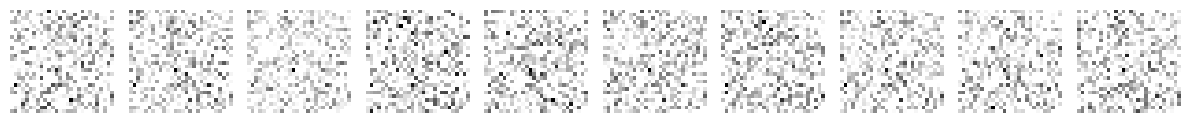

In [15]:
plot_generated()

In [16]:
X.shape[0]

60000

In [17]:
X.shape[0] // 1024

58

In [18]:
def fit(epochs=20, plot_interval=5, batch_size=1024):
    no_of_batches = X.shape[0] // 1024
    for i in tqdm(range(1, epochs+1), desc='Training Progress'):
        print(f'------------- Epoch {i} -------------')
        for j in range(no_of_batches):
            # Taking Real Images 
            batch_images = X[np.random.randint(0, 60_000, size=batch_size)]
            
            # Taking Fake Images (images from geneator)
            random_noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            generated_image = generator.predict(random_noise, verbose=0)
            
            # preparing datset with half fake and half real images
            X_train = np.concatenate((batch_images, generated_image))
            y_train = np.concatenate((np.ones(batch_size), np.zeros(batch_size)))
            
            # Training Discriminator only
            discriminator.trainable = True
            dis_loss = discriminator.train_on_batch(X_train, y_train)
            
            # Training Generator only (GAN)
            discriminator.trainable = False
            X_gan = np.random.normal(0, 1, size=(batch_size*2, noise_dim))
            y_gan = np.ones(batch_size*2)
            gan_loss = gan.train_on_batch(X_gan, y_gan)
        losses['D'].append(dis_loss)
        losses['G'].append(gan_loss)
        if i == 1 or i%5 == 0:
            plot_generated()

In [ ]:
fit()

Training Progress:   0%|                                                                        | 0/20 [00:00<?, ?it/s]

------------- Epoch 1 -------------
